# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Задача**

Построить модель для определения стоимости автомобиля. Необходимо учесть условия, которые важны для заказчика:
- качество предсказания (метрика RMSE < 2500);
- скорость предсказания;
- время обучения.

**План исследования**

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение моделей
6. Общий вывод

Согласно документации к данным, данные находятся в файле `autos.csv` и содержит следующие признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)

## Изучение данных

### Иморт библиотек

In [5]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Импортируем классы для машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn.impute import SimpleImputer

# Импортируем метрику для оценки качества модели
from sklearn.metrics import mean_squared_error

# Импортируем сторонние библиотеки
import phik
from phik.report import plot_correlation_matrix

import missingno as msno

from lightgbm import LGBMRegressor

In [6]:
# Для игнорирования предупреждений
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

### Функции

In [7]:
def normality_chek(data):
    '''
    Функция проверяет данные на нормальное
    распределения, исполльзуя тест Шапиро-Уилка
    Принимает столбец и сверяет его p-value с уровнем
    статистической значимости и выводит ответ о нормальности
    
    '''

    alpha = 0.05

    stat, p = shapiro(data)

    if p > alpha:
        print('Не отвергаем H0. Нормальное распределение')
    else:
        print('Отвергаем H0. Ненормальное распределение')

### Константы

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка данных

Прочитаем файл `autos.csv` и сохраним его в `autos`

In [9]:
pth = r"C:\Users\stepa\Downloads\autos.csv"

In [10]:
if os.path.exists(pth):
    autos = pd.read_csv(pth)
else:
    print('Ошибка')

Выведем первые 5 строк полученной таблицы

In [11]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на общую информацию о данных в таблице

In [12]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [13]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Рассмотрим полученную информацию подробнее.

Всего в таблице 16 столбцов, тип данных - `int`(7) и `object`(9). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из описательной статистики можно заметить странные значение в столбцах `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures`. У них в качестве минимального значения 0. А столбец `NumberOfPictures` и вовсе весь стоит из нулей. Необходимо их подробнее изучить. Столбец `RegistrationYear` имеет аномально большие значения.

Также стоит поменять тип данных в столбцах с датами и привести к типу данных `Datetime`.

### Вывод

Каждая сторка таблицы содержит информацию об анкете по продаже автомобилей. Что необходимо будет сделать:

- Были обнаружены пропуски надо их заполнить
- Сделать проверку на явные и неявные дубликаты.
- Изменить тип данных у столбцов с датами
- При исследовательском анализе более пристальное внимание уделить столбцам `Price`, `Power`, `RegistrationYear`, `RegistrationMonth` и `NumberOfPictures`, так как судя по описательной статистики в них есть аномальные значения.

## Предобработка данных
### Изменение типов данных

Поменяем тип данных в столбцах с датой.

In [14]:
columns_date = ['DateCrawled', 'DateCreated', 'LastSeen']

for date in columns_date:
    autos[date] = pd.to_datetime(autos[date], format='%Y-%m-%d %H:%M:%S')

Проверим результаты, еще раз выведем информацию о данных

In [16]:
autos.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

### Работа с пропусками

Приступим к изучению пропусков. Посмотрим в каких столбцах приствуют они, а также посчитаем процент пропущенных значений.

In [17]:
count_na = pd.Series(autos.isna().sum(), name='Пропуски')

In [18]:
proportion = pd.Series((autos.isna().sum() / len(autos)).round(4) * 100, name='Доля')

In [19]:
pd.concat([count_na, proportion], axis=1)

,Пропуски,Доля
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


Всего пропуски в 5 столбцах. В двух пропуски чуть меньше 6% от общего числа, что не так много, другие два столбца имеют долю 10% и 20%, что уже может существенно. Необходимо заполнить эти пропуски, если это возможно.

Посмотрим есть ли какая-то закономерность в пропусках и построим матрицу пропущенных значений.

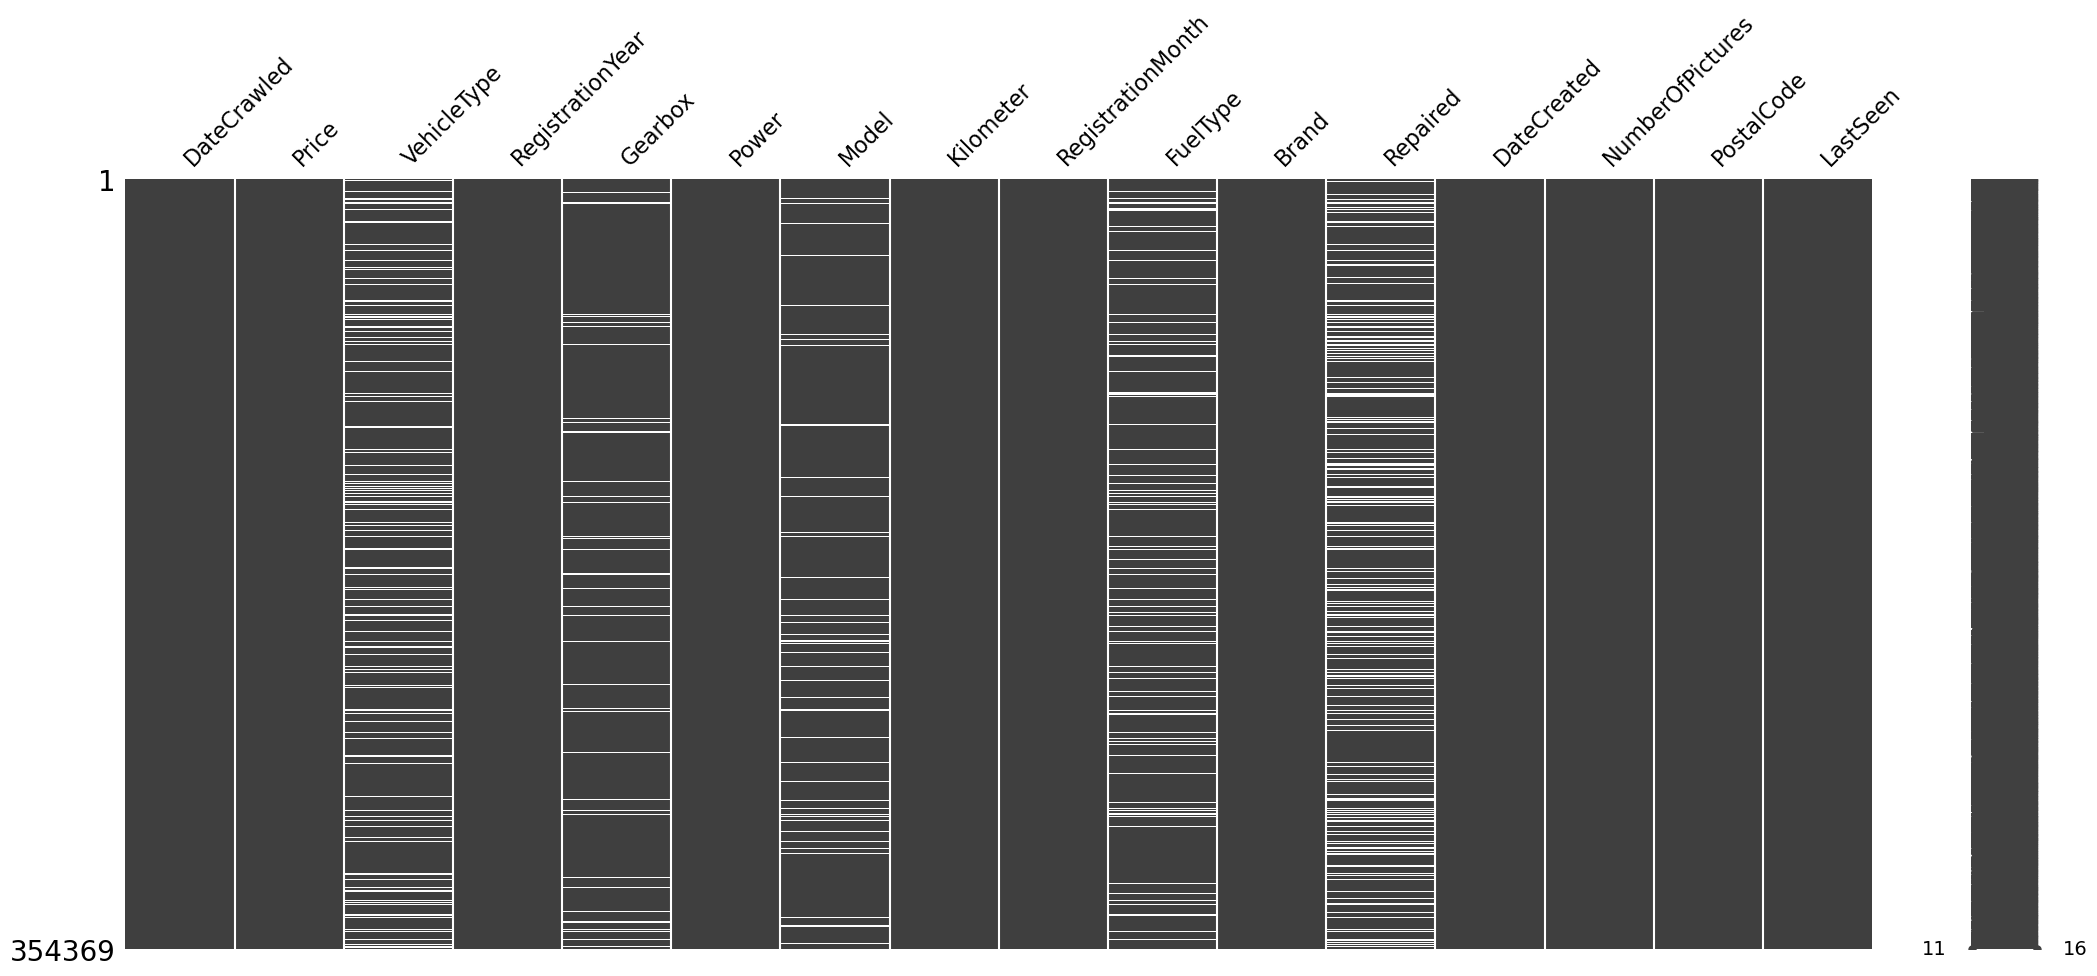

In [20]:
msno.matrix(autos);

Распределение пропущенных значений в датасете выглядит случайным.

Приступим к заполнению пропусков. Можно предположить, что в столбце `Repaired` появились пропущенные значение, так как машина не была в ремонте и поэтому ничего не указывали. Так что можно заполнить пропуски в этом столбце `no`

In [21]:
autos['Repaired'] = autos['Repaired'].fillna('no')

Посмотрим какие есть категории в каждом столбце, где остались пропуски

In [22]:
autos['VehicleType'].value_counts(dropna=False)

VehicleType
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

Видно, что есть категория `other`. В других столбцах кроме `Gearbox` также есть такая категория, поэтому заполним пропуски в них именно этой категорией.

In [23]:
na_columns = ['VehicleType', 'Model', 'FuelType']

In [24]:
for column in na_columns:
    autos[column] = autos[column].fillna('other')

Осталось заполнить только столбец `Gearbox`. К сожалению, какая-либо зависимость между значениями в этом столбце и значениями в других столбцах отсутсвует, поэтому как-то логически заполнить эти пропуски не получиться и придется использовать моду, а имеено значение `manual`.

In [25]:
autos['Gearbox'] = autos['Gearbox'].fillna('manual')

Проверим есть ли еще пропуски в данных

In [26]:
autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Работа с явными дубликатами

Проверим данные на явные дубликаты, если они есть то удалим их

In [27]:
autos.duplicated().sum()

5

In [28]:
autos = autos.drop_duplicates().reset_index(drop=True)

Еще раз проверим на явные дубликаты

In [29]:
autos.duplicated().sum()

0

### Работа с неявными дубликатами

Необходимо проверить следующие столбцы:
 - FuelType	
 - Brand	
 - Repaired 
 - VehicleType
 - Model
 - Gearbox
 
 Для этого посмотрим на все значения в этих столбцах, так как вдруг одно и тоже значение написано по-разному

In [30]:
# Считаем количество уникальных значений
fuel_type = autos['FuelType'].value_counts()
fuel_type

FuelType
petrol      216349
gasoline     98718
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: count, dtype: int64

В данном столбец неявных дубликатов нет

In [31]:
# Считаем количество уникальных значений
brand = autos['Brand'].value_counts()
brand

Brand
volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29455
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: count, dtype: int64

В данном столбец также неявные дубликаты не найдены

In [32]:
# Считаем количество уникальных значений
repaired = autos['Repaired'].value_counts()
repaired

Repaired
no     318311
yes     36053
Name: count, dtype: int64

В данном столбец также неявные дубликаты не найдены

In [33]:
# Считаем количество уникальных значений
vehicle_type = autos['VehicleType'].value_counts()
vehicle_type

VehicleType
sedan          91456
small          79830
wagon          65165
other          40778
bus            28775
convertible    20203
coupe          16161
suv            11996
Name: count, dtype: int64

Неявных дубликатов нет

In [34]:
# Считаем количество уникальных значений
gearbox = autos['Gearbox'].value_counts()
gearbox

Gearbox
manual    288081
auto       66283
Name: count, dtype: int64

Неявных дубликатов нет

In [35]:
# Считаем количество уникальных значений
model = autos['Model'].value_counts()
model

Model
other                 44125
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In [36]:
autos['Model'].unique()  # Смотрим на уникальные значения

array(['golf', 'other', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

Видно что есть несколько значений написанных по-разному, а именно:
- `range_rover` и `rangerover`. 
- `5_reihe` и `5er`
- `serie_3` и `3er`
- `serie_1` и `1er`
- `serie_2` и `2_reihe`
- `6_reihe` и `6er`

Исправим это

In [37]:
autos['Model'] = (
    autos['Model'].replace('rangerover', 'range_rover')
    .replace('5er', '5_reihe').replace('3er', 'serie_3')
    .replace('1er', 'serie_1').replace('2_reihe', 'serie_2')
    .replace('6er', '6_reihe')
)

### Вывод

На данном этапе были сделаны следующие действия:

- Изменили тип данных в столбцах с датами: `DateCrawled`, `DateCreated`, `LastSeen` на datetime.
- Сделали проверку на пропуски в данных. В результате пропуски были найдены в 5 столбцах. Столбец `Repaired` заполнили значения `no`, так как скорее всего машина не была в ремонте и поэтому ничего не указанно. В остальных случаях, к сожалению, не получилось найти какую-то логику, поэтому пустые значения были запонлены заглужкой, которая уже была в них, а именно `other`. Также столбец `Gearbox` был заполнен модой.
- Сделали проверку на явные дубликаты  и удалили их в количестве 5 штук
- Сделали проверку на неявные дубликаты и исрпавили. Было найдено несколько явных дубликатов в названиях моделей, а именно:
    - `range_rover` и `rangerover`. 
    - `5_reihe` и `5er`
    - `serie_3` и `3er`
    - `serie_1` и `1er`
    - `serie_2` и `2_reihe`
    - `6_reihe` и `6er`

## Исследовательский анализ данных

Исследуем данные в датафрейме `autos`. 
- Посмотрим на процетное соотношений категориальный признаков: `VehicleType`, `Gearbox`, `FuelType`, `Repaired`
- Изучим количественные признаки: `Price`, `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth` и `NumberOfPictures`.

Построим круговые диаграммы

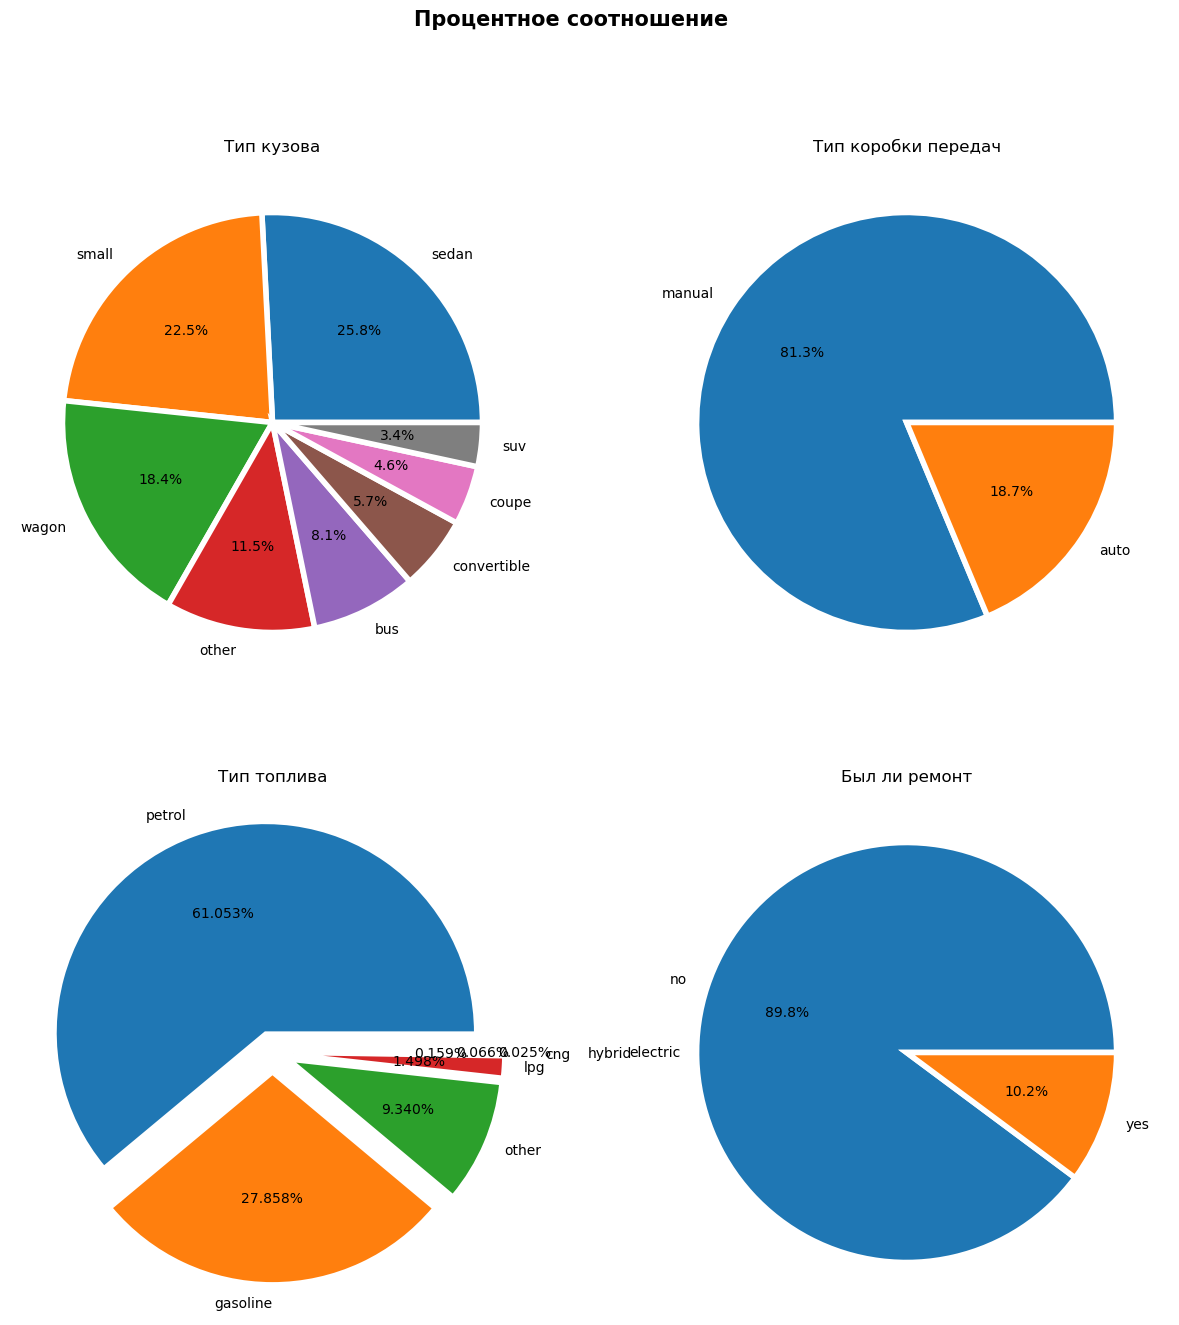

In [38]:
plt.figure(figsize=(15, 15))

plt.suptitle('Процентное соотношение', fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
plt.pie(vehicle_type.values, labels=vehicle_type.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Тип кузова')

plt.subplot(2, 2, 2)
plt.pie(gearbox.values, labels=gearbox.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Тип коробки передач')

plt.subplot(2, 2, 3)
plt.pie(fuel_type.values, labels=fuel_type.index,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'}, autopct='%.3f%%',
        explode=[0.1, 0.1, 0.1, 0.1, 0.2, 0.4, 0.6])
plt.title('Тип топлива')

plt.subplot(2, 2, 4)
plt.pie(repaired.values, labels=repaired.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'}, autopct='%.1f%%')
plt.title('Был ли ремонт');

Можно сказать следующие:

- Больше всего машин типа `sedan` - 26.9%, меньше всего `suv` - 3.4%
- У машин преобладает коробка передач `manual` - 81.3% против 18.7 у `auto`
- У большей части машин 89.9% не было ремонта
- Самое популярное топливо `petrol` - 61.1%. Наименее популярные `electric` - 0.0025%, `cng` - 0.066% и `ipg` - 0.159%

Теперь изучим количественные перменные и сначала построим диаграмму размаха.

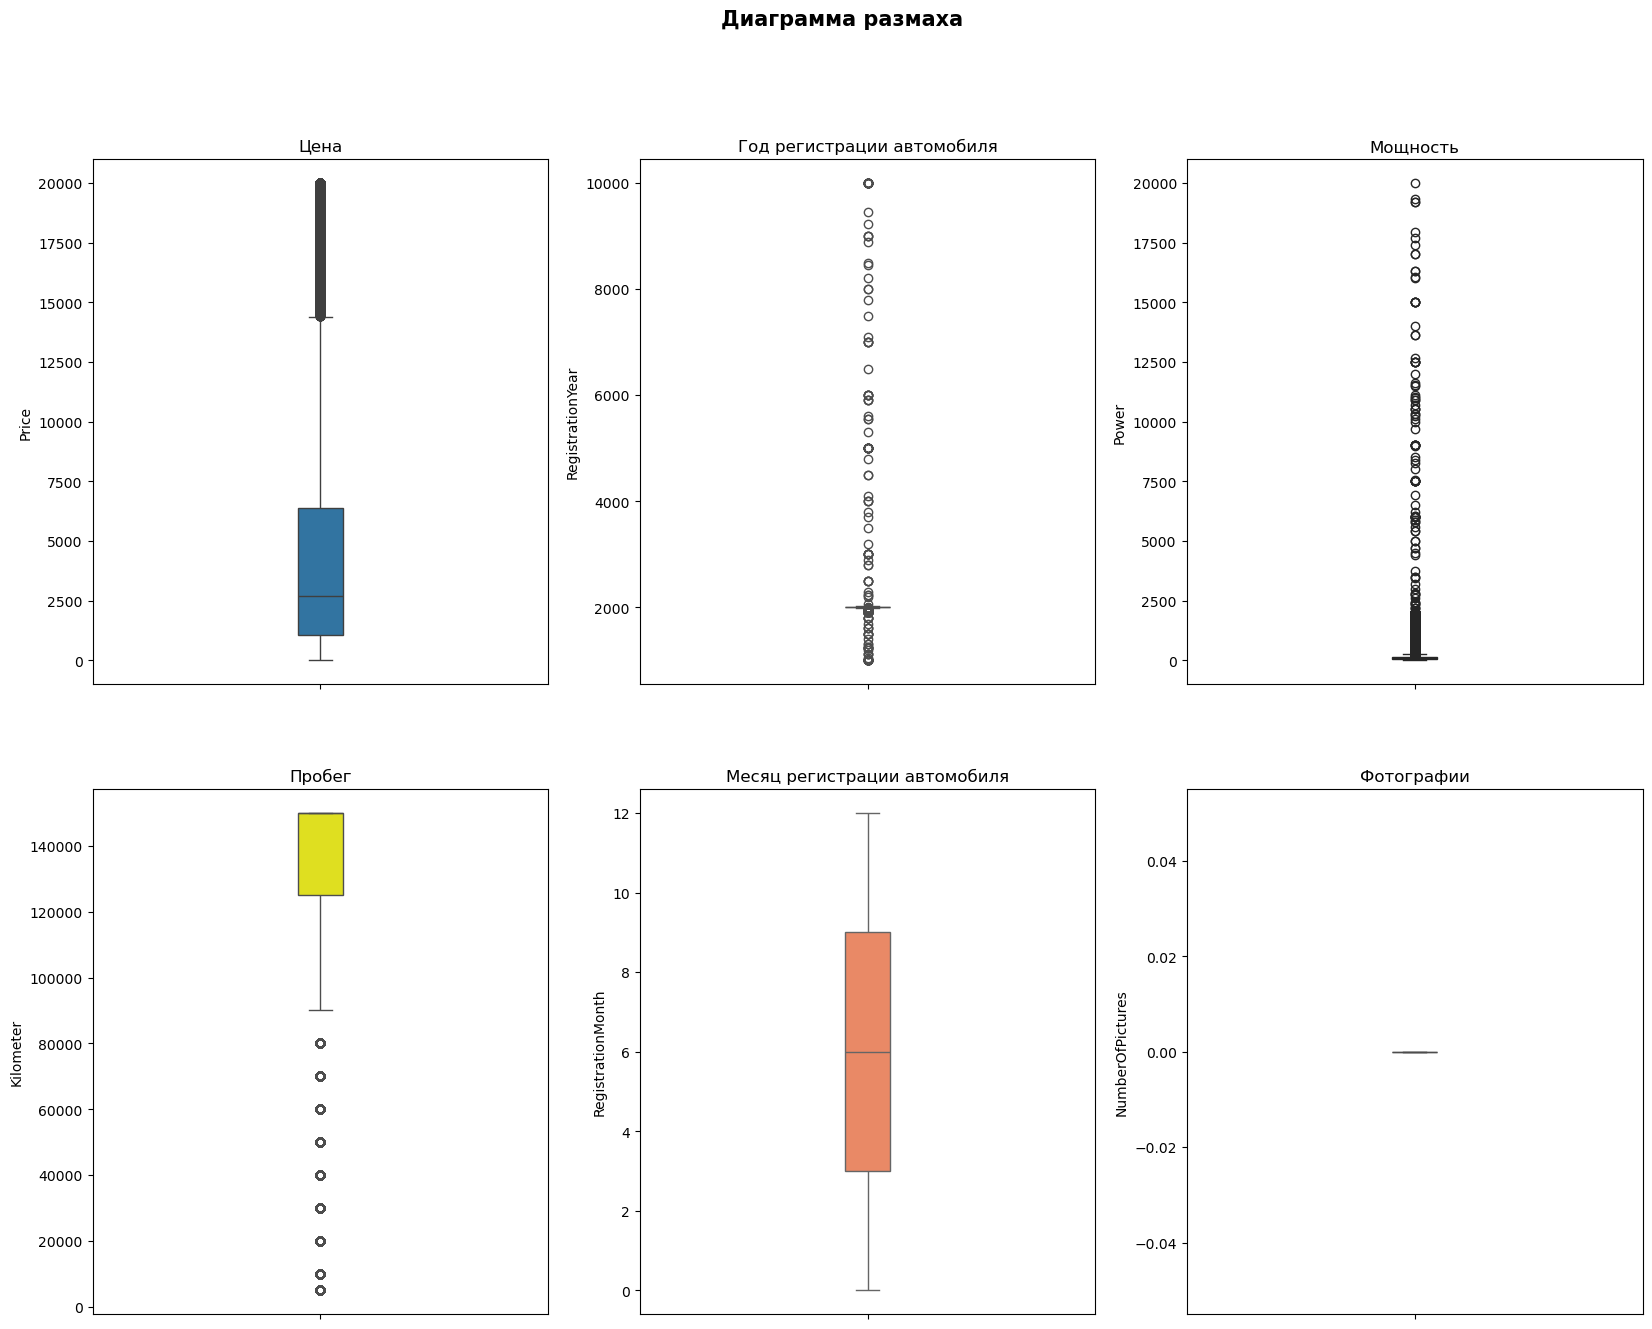

In [39]:
plt.figure(figsize=(20, 15))

plt.suptitle('Диаграмма размаха', fontsize=15, fontweight='bold')

plt.subplot(2, 3, 1)
sns.boxplot(y=autos['Price'], width=.1)
plt.title('Цена')

plt.subplot(2, 3, 2)
sns.boxplot(y=autos['RegistrationYear'], width=.1, color='red')
plt.title('Год регистрации автомобиля')

plt.subplot(2, 3, 3)
sns.boxplot(y=autos['Power'], width=.1, color='green')
plt.title('Мощность')

plt.subplot(2, 3, 4)
sns.boxplot(y=autos['Kilometer'], width=.1, color='yellow')
plt.title('Пробег')

plt.subplot(2, 3, 5)
sns.boxplot(y=autos['RegistrationMonth'], width=.1, color='coral')
plt.title('Месяц регистрации автомобиля')

plt.subplot(2, 3, 6)
sns.boxplot(y=autos['NumberOfPictures'], width=.1, color='orange')
plt.title('Фотографии');

Как уже было отмечено при изучение данных есть несколько странных столбцов `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures`. Хоть у `RegistrationMonth` и нет аномальных судя по боксплоту, но видно, что есть значение равно 0, что очень странно. Аналогичная ситуация и с другими столбцами.


Цена автомобиля может быть очень высокой, поэтому данные значения не будут аномальными, но цены равные 0 очень странно. Большие значение в столбце мощности выглядят очень странно, учитывая, что данные указаны в л.с., также странные значение равные 0. Пробег машины может быть любой, так что в такой ситуации не будем считать эти значения аномальными. У месяца регистрации, как уже отмечалось есть странные значния равные 0. Столбец с фотографиями сам по себе странный, так как весь состоит из нулей. Год регистрации также стоит проверить, так как есть значения больше 2024, что невозможно. 

Начнем с изучения значений равных 0 и построим таблицу с их количеством и долю, которую они занимают.

In [40]:
count_zero = pd.Series([len(autos[autos['RegistrationMonth'] == 0]), len(autos[autos['Price'] == 0]),
                        len(autos[autos['Power'] == 0]), len(autos[autos['NumberOfPictures'] == 0])])

In [41]:
name = pd.Series(['Месяц регистрации', 'Цена', 'Мощность', 'Фотографии'])

In [42]:
proportion_zero = pd.Series([len(autos[autos['RegistrationMonth'] == 0]) / len(autos) * 100,
                            len(autos[autos['Price'] == 0]) / len(autos) * 100,
                            len(autos[autos['Power'] == 0]) / len(autos) * 100,
                            len(autos[autos['NumberOfPictures'] == 0]) / len(autos) * 100])

In [43]:
name_df = name.to_frame(name='Признак')
count_zero_df = count_zero.to_frame(name='Количество')
proportion_zero_df = proportion_zero.to_frame(name='Доля')

In [44]:
pd.concat([name_df, count_zero_df, proportion_zero_df], axis=1)

,Признак,Количество,Доля
0,Месяц регистрации,37352,10.540574
1,Цена,10772,3.039812
2,Мощность,40225,11.351322
3,Фотографии,354364,100.000000


Столбец `NumberOfPictures` весь состоит из нулей. Причины могут быть разными как технические неполадки, так и человеческий фактор, но стоит сообщить об этом коллегами. 

Также вообще не понято по какой причине появились нули в других столбцах и их доля очень высокая, не считая только столбец `Power`. Также стоит сообщить об этом может есть какая-то ошибка в данных

Так же необходимо посмотреть столбец `Power` с другой стороны. Как видно из диаграммы максимальная мощность около 20000, что не реально, так как на данный момент самая мощная машина имеет 2028 л.с.. Так что все, что является сверх 2028 будет аномальным значением, так как исходя из документации мощность указана в л.с.

In [45]:
autos[autos['Power'] > 2028]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25,0,57520,2016-04-01 19:16:33
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5_reihe,150000,7,gasoline,bmw,no,2016-03-20,0,21376,2016-03-23 02:48:53
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,other,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341061,2016-04-03 22:57:04,449,other,2016,manual,4507,corsa,150000,4,petrol,opel,no,2016-04-03,0,29525,2016-04-06 00:16:11
341315,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,petrol,citroen,yes,2016-03-29,0,89428,2016-03-31 15:17:03
346634,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,no,2016-03-25,0,42105,2016-04-06 14:44:53
348132,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,no,2016-03-16,0,14482,2016-04-03 09:17:43


Всего 107 таких значений, что не очень много. Если взять строку 7661, в которой указан фольксваген лупо, то мощность его двигателя составляет от 50 до 135 л.с., в таком случае можно предположить, что хотели написать 75.15 л.с., но так никто не указывает л.с.. И тем более, если взять строку 19092, в которой находится bmw 5er, то мощность двигателя этого автомобиля от 86 до 530 л.с.. И если предполагая, прошлую гипотезу, что необходимо разделить все значения на 100, то в результате получиться 27.29 л.с., что не соотвествует действительности. И в таком случае эти данные лучше удалить.

In [46]:
autos = autos[autos['Power'] < 2028]

In [47]:
autos = autos.reset_index(drop=True)  # Обновим индексы строк

Построим еще раз диаграмму размаха для этого столбца

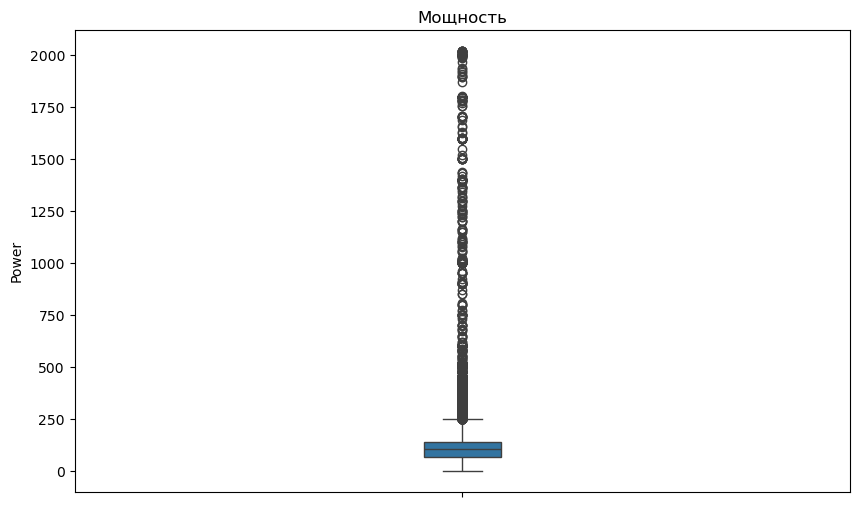

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=autos['Power'], width=.1)
plt.title('Мощность');

Хоть у нас и есть выбивающиеся значения, но по крайней мере мощность стала в реальном диапазоне

Проверим в один ли год была выгурзка данных из базы данных.

In [49]:
max(autos['DateCrawled']), min(autos['DateCrawled'])

(Timestamp('2016-04-07 14:36:58'), Timestamp('2016-03-05 14:06:22'))

Выгрузка была в один год - 2016

Теперь проверим столбец `RegistrationYear` на аномальные значения по диаграмме размаха можно увидеть значения невероятно большие стоит на них посмотреть. Выведим значения, у которых год больше 2016, так как дата выгрузки у нас была в 16 году.

In [50]:
autos[autos['RegistrationYear'] > 2016]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,other,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,other,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,other,2017,manual,80,golf,100000,1,petrol,volkswagen,no,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,other,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,other,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354000,2016-03-11 15:49:51,3600,other,2017,manual,86,transit,150000,5,gasoline,ford,no,2016-03-11,0,32339,2016-03-12 05:45:02
354028,2016-03-29 16:47:29,1000,other,2017,manual,101,a4,150000,9,other,audi,no,2016-03-29,0,38315,2016-04-06 02:44:27
354091,2016-03-17 00:56:26,2140,other,2018,manual,80,fiesta,150000,6,other,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354141,2016-03-25 09:37:59,1250,other,2018,manual,0,corsa,150000,0,petrol,opel,no,2016-03-25,0,45527,2016-04-06 07:46:13


Таких значений много (14521). Востановить данные и привести их к реальности не предоставляется возможным, поэтому их просто удалим. Также стоит сообщить коллегам, об аномальных данных, возможно, проблемы технического характера.

In [51]:
autos = autos[autos['RegistrationYear'] < 2016]

In [52]:
autos = autos.reset_index(drop=True)  # Обновим индексы строк

Еще раз построим диаграмму размаха

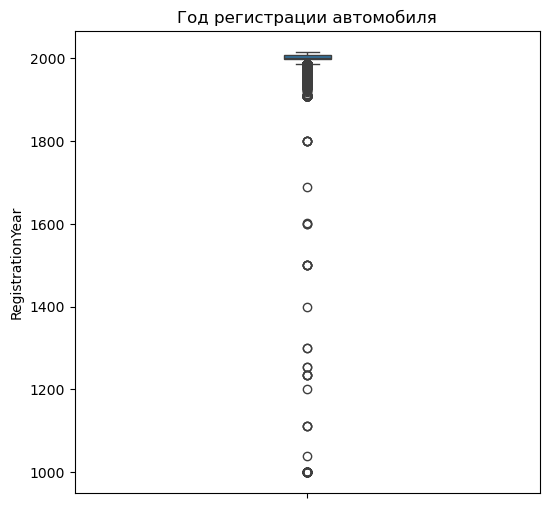

In [53]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=autos['RegistrationYear'], width=.1)
plt.title('Год регистрации автомобиля');

Посмотрим на значения меньше 1885 года (это год создания первого автомобиля) возьмем его как минимальную возможную дату (на авито выставлена машина 1912 года так что вполне реально использовать 1885 как минимальный)

In [54]:
autos[autos['RegistrationYear'] < 1885]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
569,2016-03-16 16:55:09,0,other,1111,manual,0,other,5000,0,other,opel,no,2016-03-16,0,44628,2016-03-20 16:44:37
14929,2016-03-29 23:42:16,190,other,1000,manual,0,mondeo,5000,0,other,ford,no,2016-03-29,0,47166,2016-04-06 10:44:58
16942,2016-03-09 17:49:44,7999,other,1500,manual,224,impreza,5000,3,other,subaru,no,2016-03-09,0,53577,2016-03-15 05:15:17
31945,2016-04-01 06:02:10,450,other,1800,manual,1800,other,5000,2,other,mitsubishi,no,2016-04-01,0,63322,2016-04-01 09:42:30
36182,2016-03-19 23:54:40,1234,other,1234,manual,26,other,5000,1,other,trabant,no,2016-03-19,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301377,2016-03-26 20:58:27,30,other,1000,manual,0,other,5000,0,other,audi,no,2016-03-26,0,37574,2016-04-06 12:17:27
303538,2016-03-30 11:36:35,400,other,1000,manual,0,other,5000,0,other,mercedes_benz,no,2016-03-30,0,8060,2016-04-01 06:16:46
317480,2016-04-04 23:55:47,700,other,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:07
324943,2016-03-22 00:38:15,1,other,1000,manual,1000,other,150000,0,other,sonstige_autos,no,2016-03-21,0,41472,2016-04-05 14:18:01


Всего 66 значений их также удалим.

In [55]:
autos = autos[autos['RegistrationYear'] > 1885]

In [56]:
autos = autos.reset_index(drop=True) # Обновим индексы строк

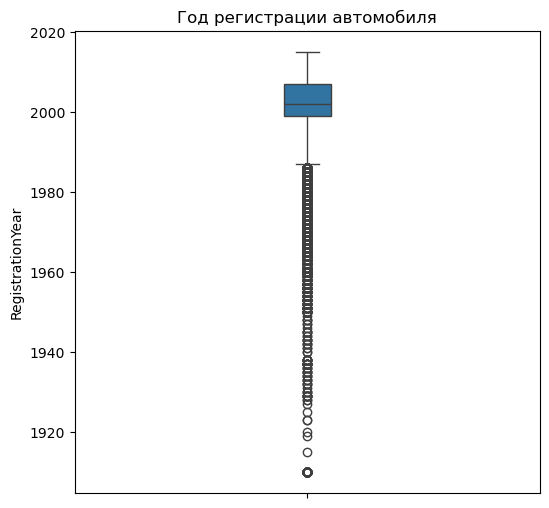

In [57]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=autos['RegistrationYear'], width=.1)
plt.title('Год регистрации автомобиля');

Выбивающиеся значения все также есть, но теперь они соотвествуют возможным удалять их не будем

Теперь построим гистограммы по количественным переменным.

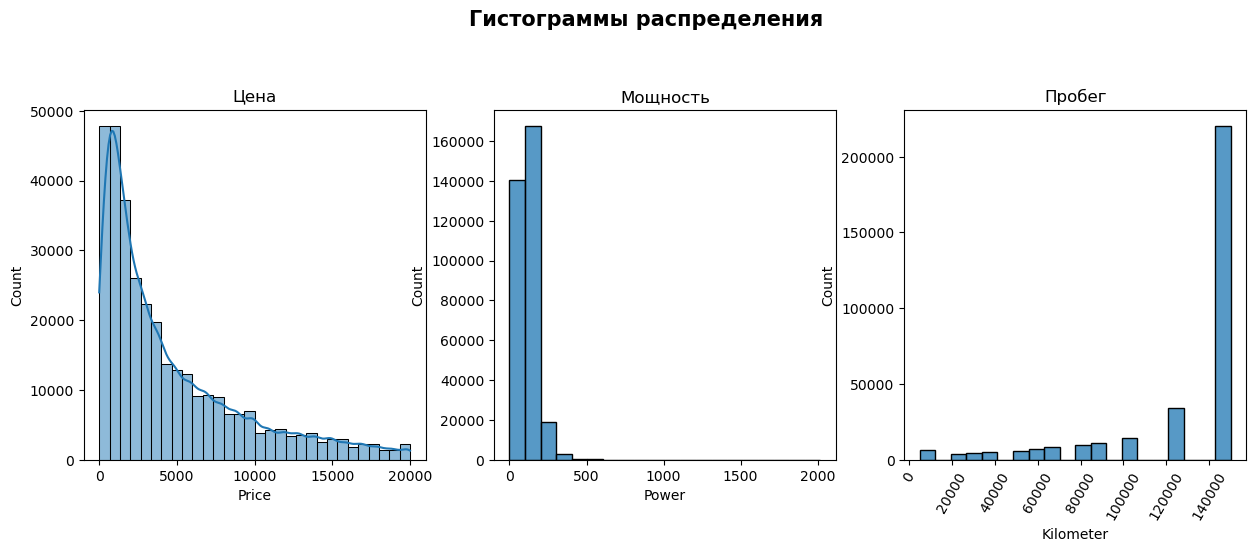

In [58]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределения', fontsize=15, fontweight='bold')

plt.subplot(2, 3, 1)
sns.histplot(autos['Price'], bins=30, kde=True)
plt.title('Цена')

plt.subplot(2, 3, 2)
sns.histplot(autos['Power'], bins=20)
plt.title('Мощность')

plt.subplot(2, 3, 3)
sns.histplot(autos['Kilometer'], bins=20)
plt.xticks(rotation=60)
plt.title('Пробег');

Данные распределенны ненормально. Можно отметить, что у автомобилей в основном пробег больше 140000. Чем дороже автомобиль, тем их меньше. Автомобилей с мощностью свыше 500 практически отсутсвуют, что соотвествует реальности.

Для того, чтобы убедится, что данные распределены не нормально воспользуемся тестом Шапиро-Уилка и для этого была написана функция `normality_chek`.

Для этого необходимо выдвинуть гипотезы о нормальности:

**H0** - данные распределены нормально

**H1** - данные распределены ненормально.

In [59]:
normality_chek(autos['Price'])

Отвергаем H0. Ненормальное распределение


In [60]:
normality_chek(autos['Power'])

Отвергаем H0. Ненормальное распределение


In [61]:
normality_chek(autos['Kilometer'])

Отвергаем H0. Ненормальное распределение


Все наши данные распределены ненормально

Изучим отдельно данные с датами

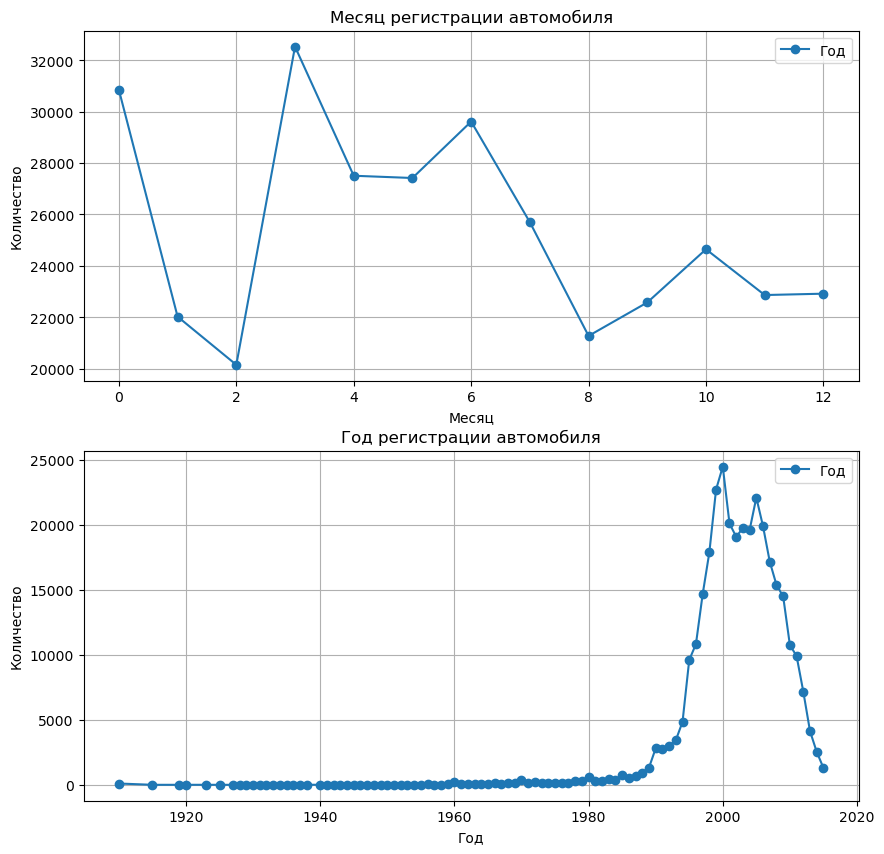

In [62]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
line_1, = (
    plt.plot(autos.groupby('RegistrationMonth')['Price']
             .count(),
             marker='o',
             label='Год')
)
plt.grid()
plt.xlabel("Месяц")
plt.ylabel("Количество")
plt.title("Месяц регистрации автомобиля")
plt.legend(handles=[line_1])

plt.subplot(2, 1, 2)
line_1, = (
    plt.plot(autos.groupby('RegistrationYear')['Price']
             .count(),
             marker='o',
             label='Год')
)
plt.grid()
plt.xlabel("Год")
plt.ylabel("Количество")
plt.title("Год регистрации автомобиля")
plt.legend(handles=[line_1]);

Чаще всего машины регистрируют в марте (если не брать аномальный 0 месяц). Наименее популярный месяц февраль.

Большинство автомобилей зарегистрированно в нулевых.

### Вывод

По результатам исследователького анализа можно сделать следующие выводы:

1. По типу топлива автомобили расположились следующим образом:
    - `petrol` - 61.05%
    - `gasoline` - 27.85%
    - `other` - 9.34%
    - `ipg` - 1.49%
    - `cng` - 0.159%
    - `hybrid` - 0.066%
    - `electric` - 0.025%
2. По типу кузова:
    - `sedan` - 26.9%
    - `small` - 22.6%
    - `wagon` - 18.4%
    - `other` - 10.3%
    - `bus` - 8.1%
    - `convertible` - 5.7%
    - `coupe` - 4.6%
    - `suv` - 3.4%
3. По типу коробки передач:
    - `manual` - 81.3%
    - `auto` - 18.7%
4. По соотношению ремонта был/не был 10.2% против 89.8%
5. Количественные признаки распределены ненормально и это также было потверждено при помощи статистического теста Шапиро-Уилка. Можно отметить, что у автомобилей в основном пробег больше 140000. Чем дороже автомобиль, тем их меньше. Автомобилей с мощностью свыше 500 практически отсутсвуют, что соотвествует реальности. Чаще всего машины регистрируют в марте (если не брать аномальный 0 месяц). Наименее популярный месяц февраль. Большинство автомобилей зарегистрированно в нулевых.
6. Были удалены аномальные значения в столбцах `Power` и `RegistrationYear`

Также стоит отметить, что данные плохо собраны. Очень много аномалий и странных значений в столбцах `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures` и их доля довольна высокая. Возможно связанно с техническими неполадками или с неправильной обработкой данных. Отдельнное внимание стоит уделить столбцу `NumberOfPictures` так как он весь состоит из нулей.

## Подготовим датафрейм

Для корреляционного анализа и для дальнейшего обучения модели, необходимо подготовить датафрейм. А именно удалим столбец `DateCrawled` это просто дата выгрузки она ни на что не будет влиять.

Также стоит преобразовать два столбца с датами, так как если их оставить то будет слишком много уникальных значений. Посмотрим на диапазон даты создания анекты и последней активности.

In [63]:
max(autos['DateCreated']), min(autos['DateCreated'])

(Timestamp('2016-04-07 00:00:00'), Timestamp('2014-03-10 00:00:00'))

In [64]:
max(autos['LastSeen']), min(autos['LastSeen'])

(Timestamp('2016-04-07 14:58:51'), Timestamp('2016-03-05 14:15:08'))

Из столбца `DateCreated` выделим месяц и создаим столбец `MonthCreated`. А из столбца `LastSeen` выделим день и создадим столбец `DayLastSeen`. Так мы уменьшим количество уникальных значений в этих столбцах.

In [65]:
autos['MonthCreated'] = autos['DateCreated'].apply(lambda x: x.month)

In [66]:
autos['DayLastSeen'] = autos['LastSeen'].apply(lambda x: x.day)

Проверим все ли получилось и выведем первые 5 строк

In [67]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,DayLastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57,3,7
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,3,7
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46,3,5
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,3,17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,3,6


Теперь можно удалять столбцы, также помимо столбцов с датами будет удален столбец `NumberOfPictures`, так как от него нет никакой пользы (он содержит только 0)

In [68]:
autos = autos.drop(columns=['NumberOfPictures',
                   'DateCreated', 'LastSeen', 'DateCrawled'], axis=1)

In [69]:
autos.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode', 'MonthCreated', 'DayLastSeen'],
      dtype='object')

Все столбцы успешно удалены

## Корреляционные анализ

Исходя из исследовательского анализа выяснили, что наши данные распределены ненормально, поэтому для изучения взаимосвязи воспользуемся коэффициентом корреляции $\phi_k$.

In [71]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = (
    autos.phik_matrix(
        interval_cols=['Price', 'Power', 'Kilometer', 'RegistrationYear', 'PostalCode'])
)

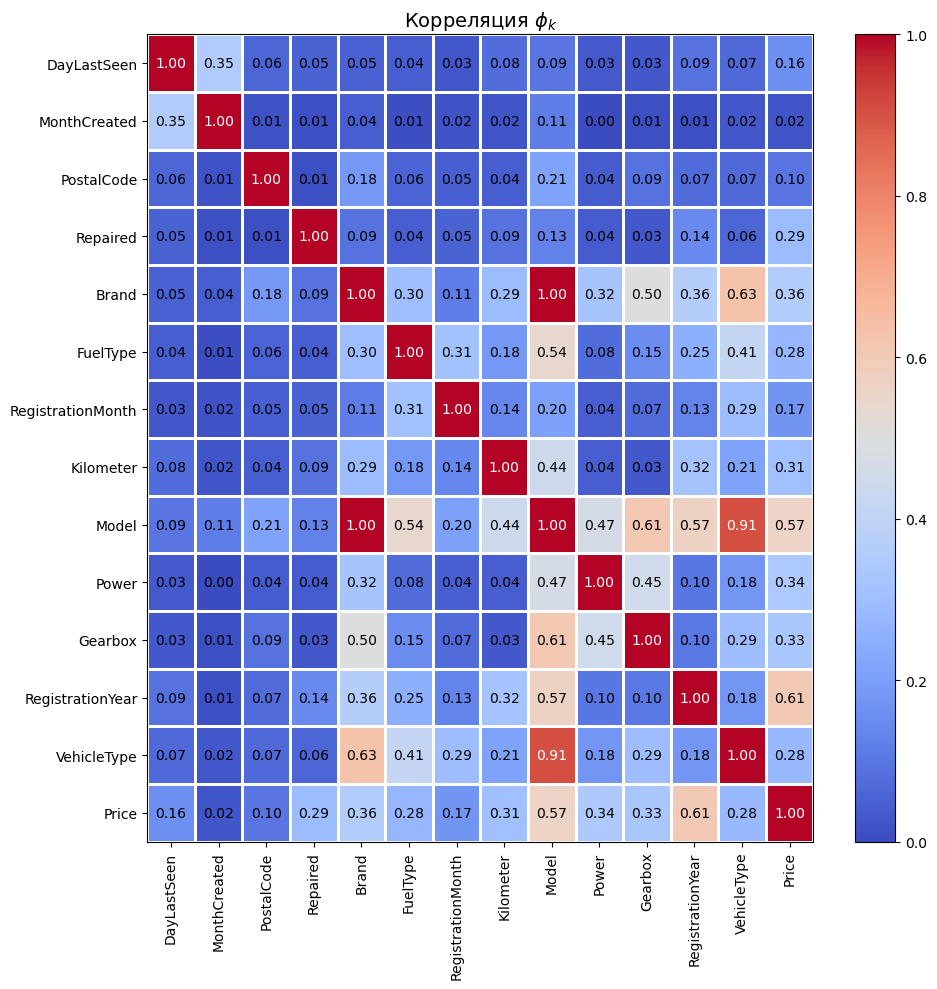

In [72]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(10, 10))

plt.tight_layout()

Наш целевой признак `Price` посмотрим как он взаимодействует с входными признаками.

Есть взаимосвязь с `RegistrationYear` - 0.61 и с `Model` - 0.57. Также есть слабая взаимосвязь `Brand` - 0.36, `Power` - 0.34, `Gearbox` - 0.33, `Kilometer` - 0.31, `Repaired` - 0.29, `VehicleType` - 0.28
С признаками `DayLastSeen`, `MonthCreated`, `PosalCode` и `RegistrationMonth` сложно судить о взаимосвязи - 0.16, 0.02, 0.1 и 0.17 соотвествено.

Также изучим все взаимосвязи между признаками.

Есть сильная взаимосвязь между `Model` и `VehicleType` - 0.91. Есть взаимосвязь между `Model` и `Gearbox` - 0.61, `RegistrationYear` и `Price` - 0.61, `Model` и `RegistrationYear` - 0.57, `Model` и `Price` - 0.57, `FuelType` и `Model` - 0.54, `Gearbox` и `Brand` - 0.5, `Model` и `Power` - 0.47, `Power` и `Gearbox` - 0.45, `Kilometer` и `Model` - 0.44

Есть мультиколлинеарность между `Model` и `Brand` необходимо от нее избавится, поэтому удалим столбец `Brand`, так как у него взаимосвязь с нашим целевым признаком слабее.

Также стоит обратить внимание, что столбцы `DayLastSeen`, `MonthCreated` и `RegistrationMonth` не имеют ни с кем взаимосвязи их стоит удалить, чтобы уменьшить количество признаков и улучшить качество обучения.

In [73]:
autos = autos.drop(
    columns=['DayLastSeen', 'MonthCreated', 'RegistrationMonth', 'Brand'], axis=1)

Еще раз построим матрицу корреляции

In [74]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = (
    autos.phik_matrix(
        interval_cols=['Price', 'Power', 'Kilometer', 'RegistrationYear', 'PostalCode'])
)

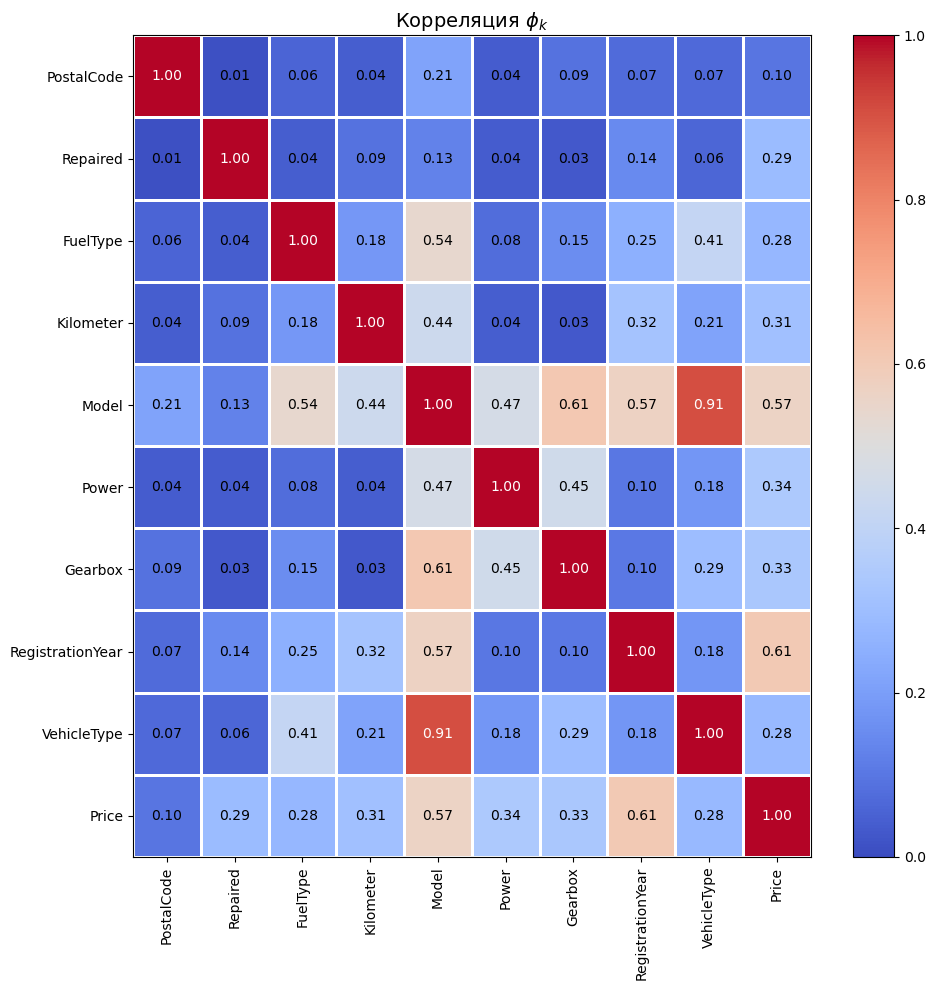

In [75]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(10, 10))

plt.tight_layout()

Избавились от мультиколлинеарности и лишних признаков.

## Обучение моделей

Приступим к обучению модели. Перед нами стоит задача регрессии наш целевой признак `Price`. Перед обучение разделим данные на тестовые и тренировочные.

Обучать будем три модели:
- `LinearRegression`
- `LGBMRegressor`
- `DecisionTreeRegressor`

Перед обучением необходимо будет закодировать и от масштабировать признаки для этого воспользуемся `StandardScaler` - для числовых, `OneHotEncoder` и `OrdinalEncoder` для категориальных признаков. Параметры для `LGBMRegressor` и `DecisionTreeRegressor` будем подибрать с помощью `RandomizedSearchCV`.

После обучения проведен проверку на адекватность с помощью `DummyRegressor`.

Оценивать модели будем по метрике `RMSE` по условиям заказчика она не должна превышать 2500. Также необходимо учитывать время обучения модели и время предсказания модели.

Подготовим выборки

In [76]:
X = autos.drop(columns='Price', axis=1)
y = autos['Price']

In [77]:
# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

Посмотрим на размеры выборок, чтобы убедиться, что все разбиение прошло правильно

In [78]:
X_train.shape, y_train.shape

((247558, 9), (247558,))

In [79]:
X_test.shape, y_test.shape

((82520, 9), (82520,))

Подготавливаем столбцы для пайплайна

In [80]:
# Создаём списки с названиями признаков
ohe_columns = ['Model', 'Gearbox', 'VehicleType', 'FuelType']
ord_columns = ['Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']

In [81]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
                    )

In [82]:
# Cоздаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(categories=[['yes', 'no']],
                            handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant'))]
)

In [83]:
# Cоздаём пайплайн для подготовки признаков из списка num_columns
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=0)),
    ('num', StandardScaler())]
)

In [84]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)],
    remainder='passthrough'
)

In [85]:
# Пайплайн data_preprocessor применям к тренировочной, тестовой выборкам.
X_train_p = data_preprocessor.fit_transform(X_train)
X_test_p = data_preprocessor.transform(X_test)

### LinearRegression

Начнем с `LinearRegression`.

In [86]:
# Инициализируем модель линейной регрессии
model_lr = LinearRegression()

In [87]:
%%time
model_lr.fit(X_train_p, y_train)

CPU times: total: 6.89 s
Wall time: 2.45 s


LinearRegression()

6.89 секунд уходит на обучение модели при помощи LinearRegression

In [88]:
%%time
rmse_lr = cross_val_score(model_lr, X_train_p, y_train, scoring='neg_root_mean_squared_error', 
                           cv=5, n_jobs=-1, error_score='raise')

CPU times: total: 766 ms
Wall time: 9.05 s


0.77 секунд тратится на предсказание моделью LinearRegression

In [89]:
print(f'Метрика RMSE на кросс-валидации: {np.mean(rmse_lr):.2f}')
print(f'Отклонение метрики RMSE: {np.std(rmse_lr):.2f}')

Метрика RMSE на кросс-валидации: -2872.28
Отклонение метрики RMSE: 22.59


### LGBMRegressor

Приступим к обучению второй модели и воспользуемся градиентным бустингом `LGBMRegressor` и фиксированым параметром `reg_alpha` =0.3. Параметры этой модели будем подбирать с помощью `RandomizedSearchCV`:
- `num_leaves`
- `n_estimators`

In [90]:
lgb_reg = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, reg_alpha=0.3)

In [91]:
# Создаём словарь со значениями гиперпараметров для перебора
parameters_lgb = {
    'num_leaves': [31, 41],
    'n_estimators': [100, 150]
}

In [92]:
# Инициализируем класс для случайного поиска
randomized_search_lgb = RandomizedSearchCV(
    lgb_reg,
    parameters_lgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [93]:
%%time
randomized_search_lgb.fit(X_train_p, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 247558, number of used features: 248
[LightGBM] [Info] Start training from score 4541.808546
CPU times: total: 5.67 s
Wall time: 21.9 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(n_jobs=-1, random_state=42,
                                           reg_alpha=0.3),
                   n_jobs=-1,
                   param_distributions={'n_estimators': [100, 150],
                                        'num_leaves': [31, 41]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [94]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_lgb.best_estimator_)

print(f'Метрика f1 на кросс-валидации: \
{randomized_search_lgb.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_lgb.cv_results_)["std_test_score"].mean():.2f}')

print(f'Cреднее время, затраченное на предсказание: \
{pd.DataFrame(randomized_search_lgb.cv_results_)["mean_score_time"].mean():.2f}')

Лучшая модель и её параметры:

 LGBMRegressor(n_estimators=150, n_jobs=-1, num_leaves=41, random_state=42,
              reg_alpha=0.3)
Метрика f1 на кросс-валидации: -1784.28
Отклонение метрики на кросс-валидации: 16.85
Cреднее время, затраченное на предсказание: 0.12


### DecisionTreeRegressor

Приступим к обучение третей модели, а именно `DecisionTreeRegressor` у этой модели будем подбирать параметры при помощи `RandomizedSearchCV`: 
- `min_samples_split`
- `min_samples_leaf`

In [95]:
# Инициализируем модель дерева решений
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [96]:
# Создаём словарь со значениями гиперпараметров для перебора
parameters_tree = {
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 8)
}

In [97]:
# Инициализируем класс для случайного поиска
randomized_search_tree = RandomizedSearchCV(
    model_tree,
    parameters_tree,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [98]:
%%time
randomized_search_tree.fit(X_train_p, y_train)

CPU times: total: 2.38 s
Wall time: 1min 42s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'min_samples_leaf': range(1, 8),
                                        'min_samples_split': range(2, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [99]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_tree.best_estimator_)

print(f'Метрика f1 на кросс-валидации: \
{randomized_search_tree.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_tree.cv_results_)["std_test_score"].mean():.2f}')

print(f'Cреднее время, затраченное на предсказание: \
{pd.DataFrame(randomized_search_tree.cv_results_)["mean_score_time"].mean():.2f}')

Лучшая модель и её параметры:

 DecisionTreeRegressor(min_samples_leaf=7, min_samples_split=4, random_state=42)
Метрика f1 на кросс-валидации: -2000.00
Отклонение метрики на кросс-валидации: 18.12
Cреднее время, затраченное на предсказание: 0.12


### Проверка моделей на адекватность

Проверим модели на адекватность, сравнив качество предсказаний с качеством модели, которая предсказывала бы константу.

Для этого воспользуемся `DummyRegressor`. Главное, чтобы ее показания были хуже, чем у обученых нами моделей.

In [100]:
model_dr = DummyRegressor(strategy='mean')

In [101]:
%%time
model_dr.fit(X_train_p, y_train)

CPU times: total: 0 ns
Wall time: 505 µs


DummyRegressor()

In [102]:
%%time
rmse_dummy = cross_val_score(model_dr, X_train_p, y_train, scoring='neg_root_mean_squared_error', 
                           cv=5, n_jobs=-1, error_score='raise')

CPU times: total: 46.9 ms
Wall time: 8.11 s


In [103]:
print(f'Метрика RMSE на кросс-валидации: {np.mean(rmse_dummy):.2f}')
print(f'Отклонение метрики RMSE: {np.std(rmse_dummy):.2f}')

Метрика RMSE на кросс-валидации: -4568.65
Отклонение метрики RMSE: 8.92


Хоть по времени модели обученные медлнее, но зато по метрикам превосходят, а значит все модели прошли проверку на адекватность

### Анализ моделей

Обобщим всю полученную информацию и про анализируем результаты

| **Модели**  | **Время обучения**  | **Время предсаказания** | **RMSE** | **Отклонение метрики** | **Прошла проверку на адекватность** | **Удовлетворяет условию** |
|:------------- |:---------------:| :-------------:| :-------------:| :-------------:|:-------------:| :-------------:|
| **LinearRegression** | 3 сек.  | 0.77 сек. |<span style="color:red"> 2872.28</span> | 22.59 | ✅ | ❌ |
| **LGBMRegressor** | 22 сек.| 12 сек.|<span style="color:green"> 1784.28</span>| 16.85 | ✅ | ✅ |
| **DecisionTreeRegressor** | 1 мин. 42 cек.| 12 сек.   |<span style="color:green"> 2000</span>| 18.12 | ✅ | ✅ |

Как видно из таблицы только две модели из трех удовлетворяют условиям заказчика. Модель `LinearRegression` не подходит, так как метрика превышает 2500.

Необходимо выбрать из оставшихся двух. Модель обученная при помощи `LGBMRegressor` выигрывает по всем пунктам заказчика у `DecisionTreeRegressor`. Поэтому выбираем `LGBMRegressor` и проверим её качество на тестовой выборке.

In [104]:
predict = randomized_search_lgb.predict(X_test_p)

In [105]:
# Расчитываем корень среднеквадратичной ошибки
rmse = mean_squared_error(y_test, predict, squared=False)

In [106]:
print('Корень срденеквадатичной ошибки =', round(rmse, 2))

Корень срденеквадатичной ошибки = 1790.08


Модель показывает результат такое же как и на тренировочной выборке и удовлетворяет всем условиям.

Посмотрим какие признаки модель считает наиболее важными.

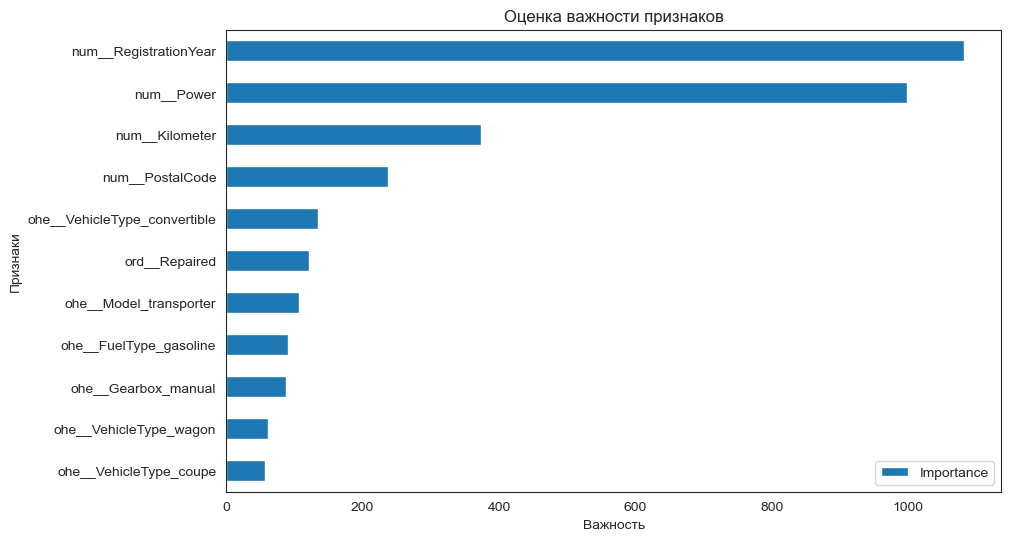

In [107]:
coefficients = randomized_search_lgb.best_estimator_.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame(
    {'Feature': data_preprocessor.get_feature_names_out(), 'Importance': np.abs(coefficients)})

feature_importance = feature_importance.sort_values(
    'Importance', ascending=False).reset_index(drop=True)

(
    feature_importance.loc[:10]
    .sort_values(by='Importance', ascending=True)
    .plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

)

plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')

Наиболее важными признаками являются год регистрации автомобиля `RegistrationYear` и мощность автомобиля `Power`. Также важными признакми являются километраж `Kilometer` и почтовый индекс `PostalCode` это можно объяснить так, что модель нашла взаимосвязь между ценой и географическим положением, так как цена на одну и ту же машину может сильно отличаться в зависимости от региона.

## Общий вывод

Данные были получены из файла:

- `autos.csv`

Сначала был сделан обзор данных. Само исследование проходило в 6 этапов:

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение моделей
6. Общий вывод

**1.Обзор данных**

Загрузили данные в переменную `autos`

Всего в таблице 16 столбцов, тип данных - `int`(7) и `object`(9). Количестов значений в столбцах разное, а значит есть пропуски. Название столбцов соотвествует стилю. Исходя из описательной статистики можно заметить странные значение в столбцах `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures`. У них в качестве минимального значения 0. А столбец `NumberOfPictures` и вовсе весь стоит из нулей. Необходимо их подробнее изучить. Столбец `RegistrationYear` имеет аномально большие значения.

Также стоит поменять тип данных в столбцах с датами и привести к типу данных `Datetime`.

**2. Предобработка данных**

На данном этапе были сделаны следующие действия:

- Изменили тип данных в столбцах с датами: `DateCrawled`, `DateCreated`, `LastSeen` на datetime.
- Сделали проверку на пропуски в данных. В результате пропуски были найдены в 5 столбцах. Столбец `Repaired` заполнили значения `no`, так как скорее всего машина не была в ремонте и поэтому ничего не указанно. В остальных случаях, к сожалению, не получилось найти какую-то логику, поэтому пустые значения были запонлены заглужкой, которая уже была в этих данных, а именно `other`. Также столбец `Gearbox` был заполнен модой (`manual`).
- Сделали проверку на явные дубликаты  и удалили их в количестве 5 штук
- Сделали проверку на неявные дубликаты и исрпавили. Было найдено несколько явных дубликатов в названиях моделей автомобилей, а именно:
    - `range_rover` и `rangerover`. 
    - `5_reihe` и `5er`
    - `serie_3` и `3er`
    - `serie_1` и `1er`
    - `serie_2` и `2_reihe`
    - `6_reihe` и `6er`
    
**3. Исследовательский анализ данных**

По результатам исследователького анализа сделали следующие выводы:

Стоит отметить, что данные плохо собраны. Очень много аномалий и странных значений в столбцах `Price`, `Power`, `RegistrationMonth` и `NumberOfPictures` и их доля довольна высокая. Возможно связанно с техническими неполадками или с неправильной обработкой данных. Отдельнное внимание стоит уделить столбцу `NumberOfPictures` так как он весь состоит из нулей.

1. По типу топлива автомобили расположились следующим образом:
    - `petrol` - 61.05%
    - `gasoline` - 27.85%
    - `other` - 9.34%
    - `ipg` - 1.49%
    - `cng` - 0.159%
    - `hybrid` - 0.066%
    - `electric` - 0.025%
2. По типу кузова:
    - `sedan` - 26.9%
    - `small` - 22.6%
    - `wagon` - 18.4%
    - `other` - 10.3%
    - `bus` - 8.1%
    - `convertible` - 5.7%
    - `coupe` - 4.6%
    - `suv` - 3.4%
3. По типу коробки передач:
    - `manual` - 81.3%
    - `auto` - 18.7%
4. По соотношению ремонта был/не был 10.2% против 89.8%
5. Количественные признаки распределены ненормально и это также было потверждено при помощи статистического теста Шапиро-Уилка. Можно отметить, что у автомобилей в основном пробег больше 140000. Чем дороже автомобиль, тем их меньше. Автомобилей с мощностью свыше 500 л.с. практически отсутсвуют, что соотвествует реальности. Чаще всего машины регистрируют в марте (если не брать аномальный 0 месяц). Наименее популярный месяц февраль. Большинство автомобилей зарегистрированно в нулевых.
6. Были удалены аномальные значения в столбцах `Power` и `RegistrationYear`

**4. Корреляционный анализ**

Перед корреляционным анализом подготовили датафрейм для дальнейшей работы. Удалили столбец `DateCrawled`, так как это просто дата выгрузки она ни на что не будет влиять. Удалили столбец `NumberOfPictures`, так как от него нет никакой пользы (он содержит только 0)

Также преобразовали два столбца с датами, так как если бы их оставили не тронутыми то было бы слишком много уникальных значений.  Из столбца `DateCreated` выделили месяц и создали столбец `MonthCreated`. А из столбца `LastSeen` выделили день и создали столбец `DayLastSeen`.

После этого приступили к корреляционному анализу. Для этого воспользовались библиотекой $\phi_k$. 

Наш целевой признак `Price`. Его взаимосвязи со всеми признаками следующие:
Есть хорошая взаимосвязь с `RegistrationYear` - 0.61 и с `Model` - 0.57. Также есть слабая взаимосвязь `Brand` - 0.36, `Power` - 0.34, `Gearbox` - 0.33, `Kilometer` - 0.31, `Repaired` - 0.29, `VehicleType` - 0.28
С признаками `DayLastSeen`, `MonthCreated`, `PosalCode` и `RegistrationMonth` сложно судить о взаимосвязи - 0.16, 0.02, 0.1 и 0.17 соотвествено.

Также изучили все взаимосвязи между входными признаками и выделили самые существенные.

Сильная взаимосвязь между `Model` и `VehicleType` - 0.91. Есть взаимосвязь между `Model` и `Gearbox` - 0.61, `RegistrationYear` и `Price` - 0.61, `Model` и `RegistrationYear` - 0.57, `Model` и `Price` - 0.57, `FuelType` и `Model` - 0.54, `Gearbox` и `Brand` - 0.5, `Model` и `Power` - 0.47, `Power` и `Gearbox` - 0.45, `Kilometer` и `Model` - 0.44

Была найдена мультиколлинеарность между `Model` и `Brand`. Избавились от нее с помощью удаления столбца `Brand`, так как у него взаимосвязь с целевым признаком слабее.

После этого удалили столбцы `DayLastSeen`, `MonthCreated` и `RegistrationMonth`, так как они не имели ни с кем взаимосвязи и они просто были лишними для обучения и только могли помешать.

**5. Обучение моделей**

Перед нами стояла задача регрессии - наш целевой признак `Price`. Перед обучение разделили данные на тестовые и тренировочные.

Обучали три модели:
- `LinearRegression`
- `LGBMRegressor` с фикисированым значеием `reg_alpha` = 0.3 и с подбором гиперпараметров `num_leaves` и `n_estimators`
- `DecisionTreeRegressor` с подбором гиперпараметров `min_samples_split` и `min_samples_leaf`

Перед обучением закодировали и от масштабировали признаки и для этого воспользовались `StandardScaler` - для числовых, `OneHotEncoder` для категориальных признаков. Гиперпараметры для `LGBMRegressor` и `DecisionTreeRegressor`  подибрали с помощью `RandomizedSearchCV`.

После обучения сделали проверку на адекватность с помощью `DummyRegressor`.

По условию заказчика оценивали модели по метрике `RMSE`, которая не должна превышать 2500. Также учитывали время обучения моделей и время предсказания моделей.

После этого был проведен обобщенный анализ моделей и была построена таблица, которая указан ниже.

| **Модели**  | **Время обучения**  | **Время предсаказания** | **RMSE** | **Отклонение метрики** | **Прошла проверку на адекватность** | **Удовлетворяет условию** |
|:------------- |:---------------:| :-------------:| :-------------:| :-------------:|:-------------:| :-------------:|
| **LinearRegression** | 3 сек.  | 0.77 сек. |<span style="color:red"> 2872.28</span> | 22.59 | ✅ | ❌ |
| **LGBMRegressor** | 22 сек.| 12 сек.|<span style="color:green"> 1784.28</span>| 16.85 | ✅ | ✅ |
| **DecisionTreeRegressor** | 1 мин. 42 cек.| 12 сек.   |<span style="color:green"> 2000</span>| 18.12 | ✅ | ✅ |

`LGBMRegressor` по всем пунктам была лучше `DecisionTreeRegressor` и поэтому выбрали ее. После этого данная модель была проверена на тестовой выборке и она показала результате `RMSE = 1790.08`

В конце посмотрели на важность признаков, которые учитывает лучшая модель. Наиболее важными признаками являются год регистрации автомобиля `RegistrationYear` и мощность автомобиля `Power`. Также важными признакми являются километраж `Kilometer` и тип кузова `VehicleType`.

**Вывод**

По результатам исследования была обучена модель, которая может предсказывает рыночную стоимость автомобиля.

Стоимость автомобиля сильно зависит от его года регистрации и мощности. Также для пользователей важен километраж и тип кузова и модель эти признаки также учитывает. 

Также на стоимость влияет `PostalCode` можно предположить из-за географического положения, так как в разных регионах разная рыночная стоимость автомобилей. Также влиет ремонт автомобиля, а именно, что он был отремонтирован. А также тип топлива.